In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### dataset information

In [5]:
from datetime import datetime
dataset = 'fmnist'
dims = (28,28,1)
umap_prop = 0.0
num_classes = 10
PROJECTION_DIMS = 128
labels_per_class = 1000#'full'
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
print(datestring)

2020_07_28_21_24_58_220013


### Load packages

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_FMNIST, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_FMNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [9]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_labeled = Y_train
    Y_masked = np.ones(len(Y_train))
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build umap graph

In [10]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [11]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

### Build data iterators

In [12]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [13]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [14]:
# make sure batch size is no bigger than the number of labels per class
labeled_batch_size = batch_size if batch_size < len(Y_labeled) else len(Y_labeled)
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)
print(labeled_batch_size)

1000


In [15]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [16]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size, repeat=True)

### Build network

In [17]:
encoder = tf.keras.Sequential()

encoder.add(tf.keras.layers.InputLayer(input_shape=dims))

# Conv + Maxpooling
encoder.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.1))

# Conv + Maxpooling
encoder.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.3))

# Converting 3D feature to 1D feature Vektor
encoder.add(tf.keras.layers.Flatten())

# Fully Connected Layer
encoder.add(tf.keras.layers.Dense(256, activation='relu'))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.5))

In [18]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=256))
# Normalization
classifier.add(tf.keras.layers.Dense(64, activation='relu'))
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [19]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(256)))
embedder.add(tf.keras.layers.Dense(units=64, activation="relu"))
embedder.add(tf.keras.layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [20]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

### Create UMAP object

In [21]:
from tfumap.semisupervised_model import PUMAP, compute_classifier_loss

In [22]:
tf.keras.backend.clear_session()
tf.compat.v1.global_variables_initializer()
tf.compat.v1.reset_default_graph()

In [23]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-3), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
    umap_prop=umap_prop
    
)

### plotting results

In [24]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


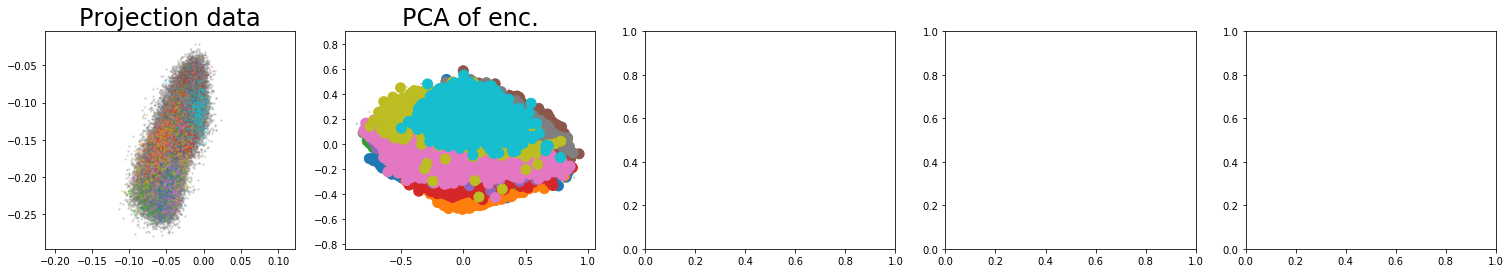

In [25]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

### Train model

In [26]:
from tfumap.paths import MODEL_DIR

In [27]:
batch = 0; epoch = 0
N_EPOCHS = 10
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)

In [28]:
# early stopping parameters
patience = 10000 # wait this many batches without improvement before early stopping
min_delta = 0.0001 # threshold for what counts as an improvement
best_acc = 0 # the best current accuracy score
last_improvement = 0 # delta between current batch, and the last batch that was an improvement
best_saved_acc = 0 # best accuracy on valid data that has been checkpointed
best_saved_batch = 0 # batch number for last good batch
max_reinitialize_delta = .01 # minimum loss in accuracy resulting in reinitialized weights
plot_frequency = 2500 # how frequently to plot
save_frequency = 2500 # how frequently to save batches
early_stopping = False
# where to save checkpoints
cpt_path = MODEL_DIR / 'semisupervised' / dataset / datestring

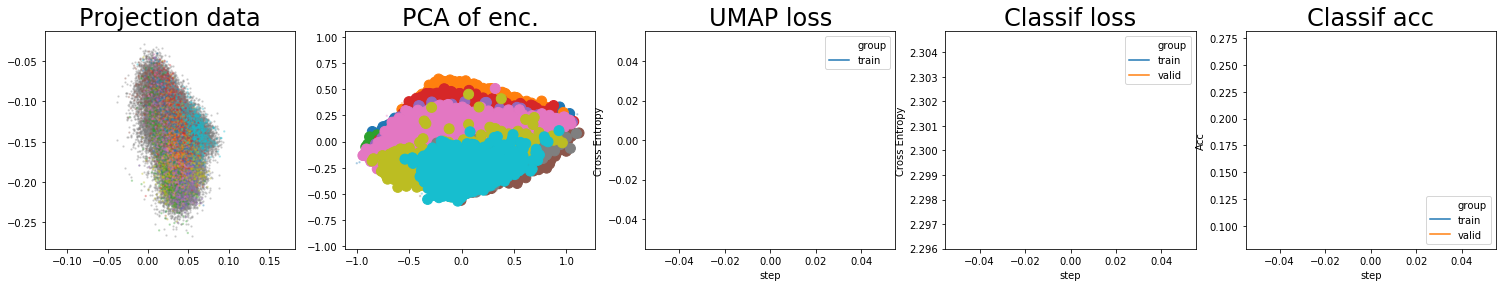

batch: 0 | train acc: 0.088 | val acc: 0.272
tf.Tensor(0.272, shape=(), dtype=float32) -0.01
saving weights


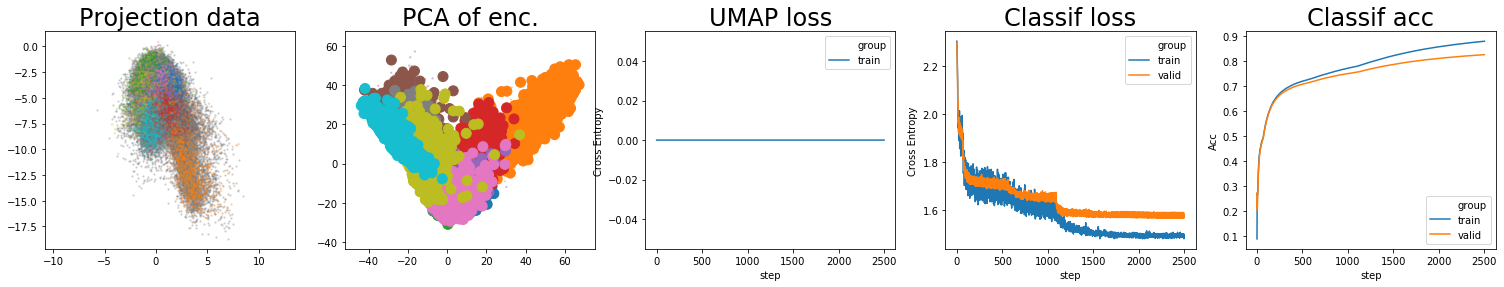

batch: 2500 | train acc: 0.8789 | val acc: 0.8252
tf.Tensor(0.82522553, shape=(), dtype=float32) 0.2620000147819519
saving weights


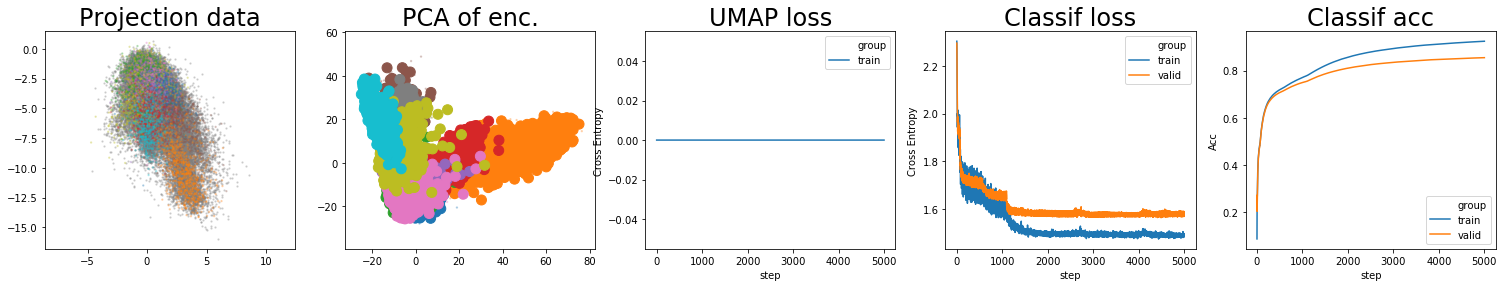

batch: 5000 | train acc: 0.9241 | val acc: 0.8547
tf.Tensor(0.85469586, shape=(), dtype=float32) 0.8152255320549011
saving weights


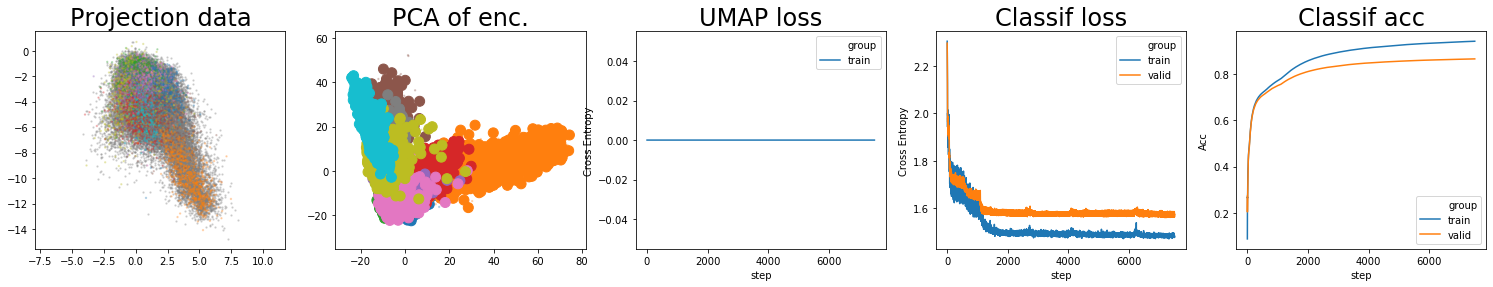

batch: 7500 | train acc: 0.941 | val acc: 0.8648
tf.Tensor(0.8648395, shape=(), dtype=float32) 0.8446958565711975
saving weights


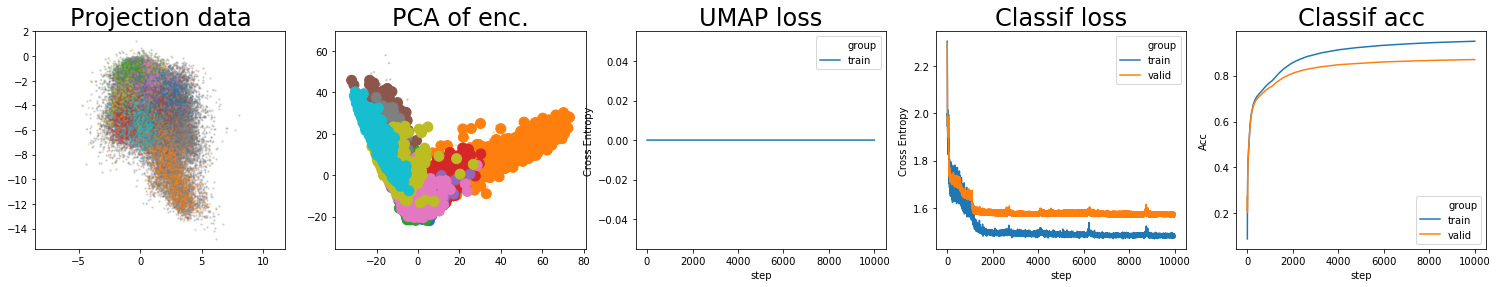

batch: 10000 | train acc: 0.9501 | val acc: 0.8702
tf.Tensor(0.87022835, shape=(), dtype=float32) 0.854839494228363
saving weights


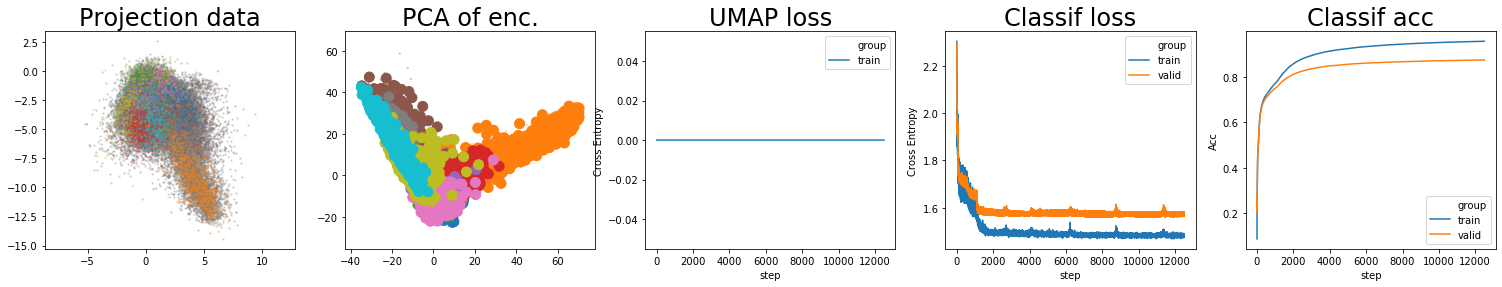

batch: 12500 | train acc: 0.9557 | val acc: 0.8737
tf.Tensor(0.8736521, shape=(), dtype=float32) 0.8602283501625061
saving weights


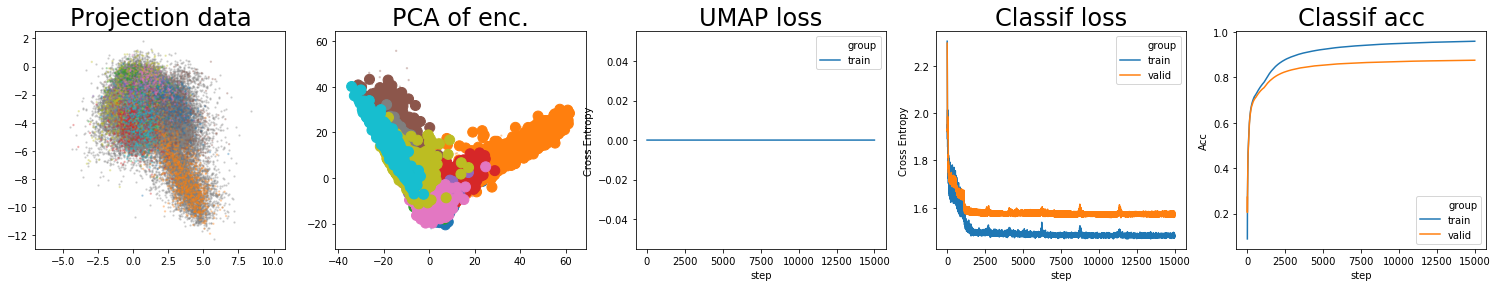

batch: 15000 | train acc: 0.9597 | val acc: 0.876
tf.Tensor(0.87601495, shape=(), dtype=float32) 0.8636521005630493
saving weights


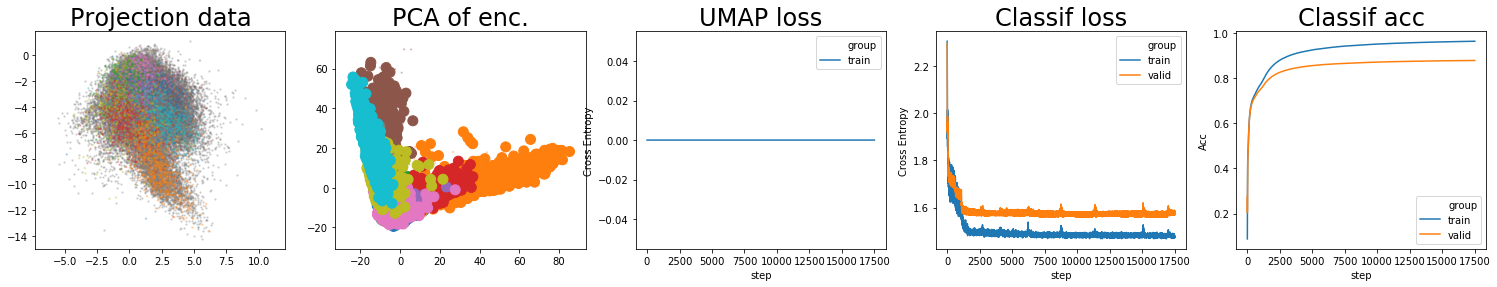

batch: 17500 | train acc: 0.9626 | val acc: 0.8775
tf.Tensor(0.8775079, shape=(), dtype=float32) 0.8660149478912353
saving weights


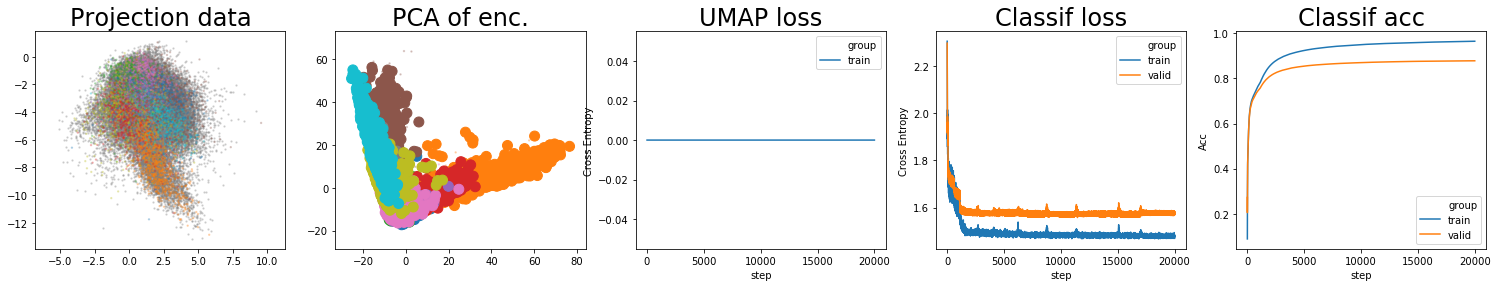

batch: 20000 | train acc: 0.9651 | val acc: 0.8783
tf.Tensor(0.8782865, shape=(), dtype=float32) 0.8675079250335693
saving weights


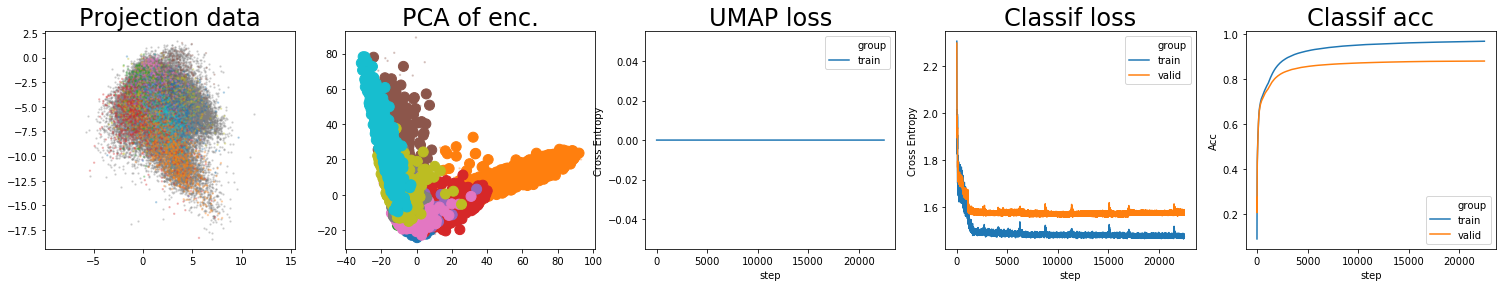

batch: 22500 | train acc: 0.9669 | val acc: 0.8789
tf.Tensor(0.87885016, shape=(), dtype=float32) 0.8682864809036255
saving weights


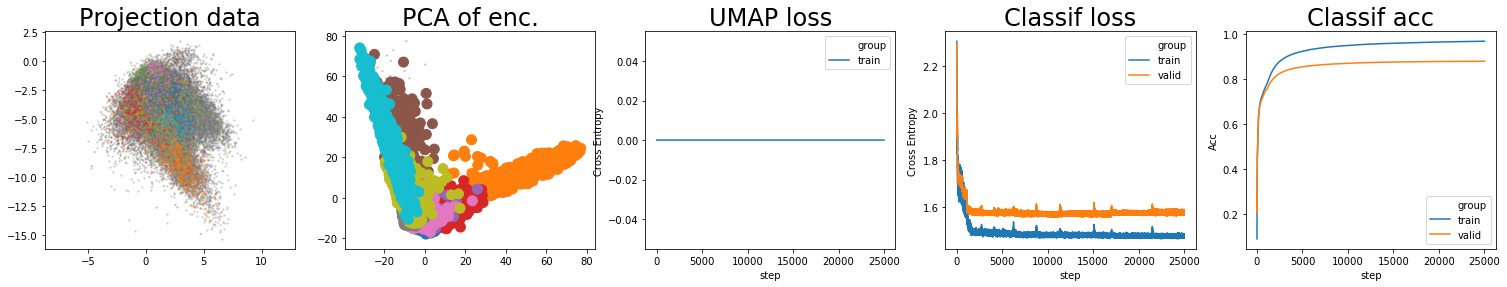

batch: 25000 | train acc: 0.9685 | val acc: 0.8793
tf.Tensor(0.8792786, shape=(), dtype=float32) 0.8688501620292663
saving weights


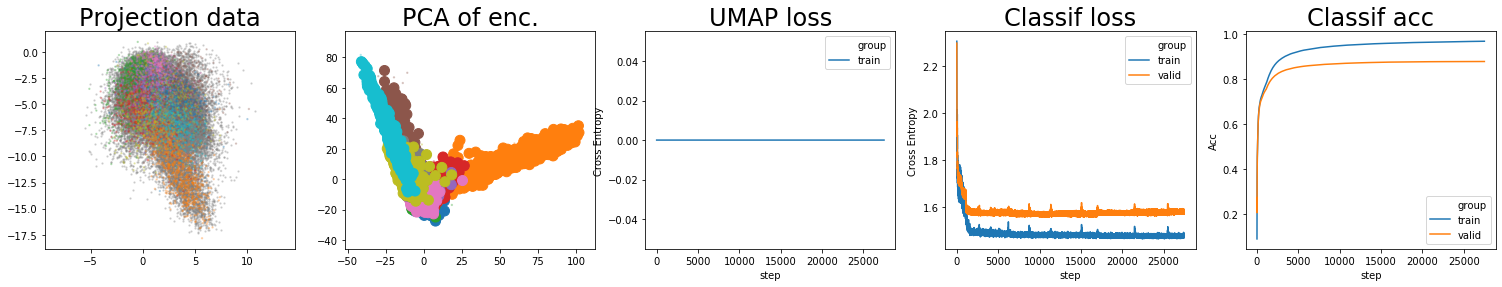

batch: 27500 | train acc: 0.9698 | val acc: 0.8795
tf.Tensor(0.8794702, shape=(), dtype=float32) 0.8692786002159119
saving weights


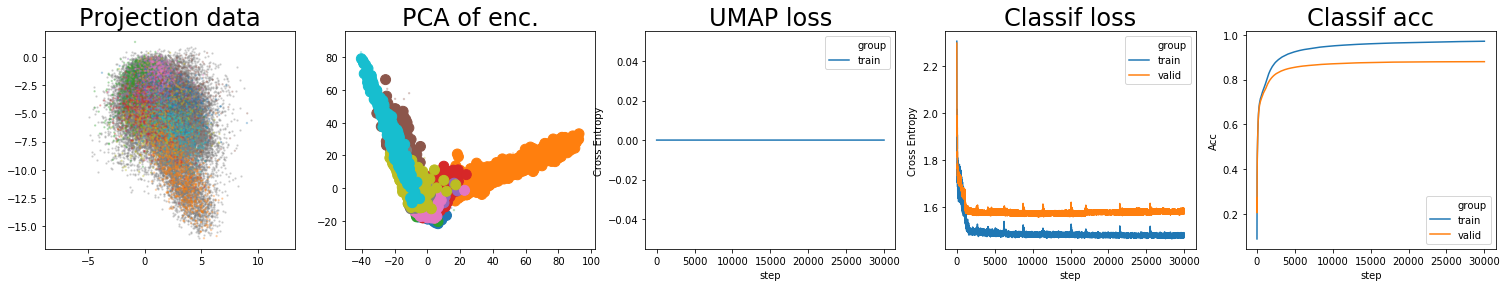

batch: 30000 | train acc: 0.9709 | val acc: 0.8797
tf.Tensor(0.8797287, shape=(), dtype=float32) 0.8694702291488647
saving weights


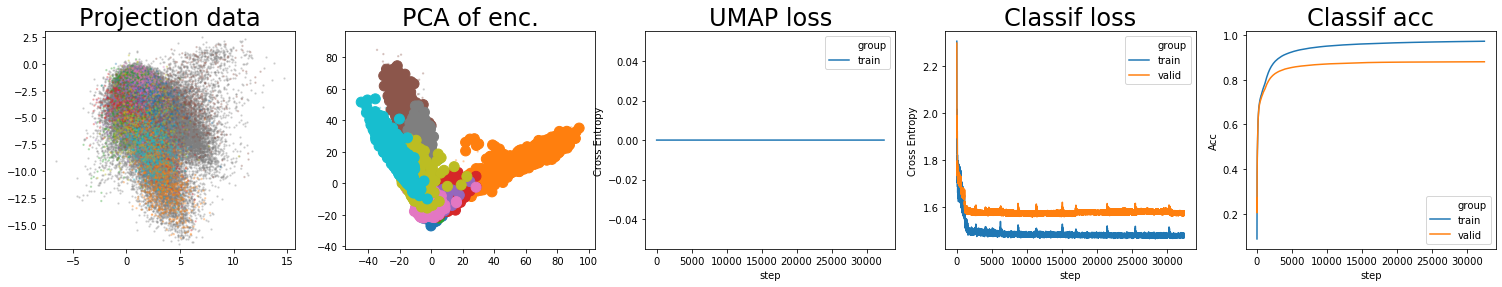

batch: 32500 | train acc: 0.9719 | val acc: 0.8801
tf.Tensor(0.8801253, shape=(), dtype=float32) 0.8697286748886108
saving weights


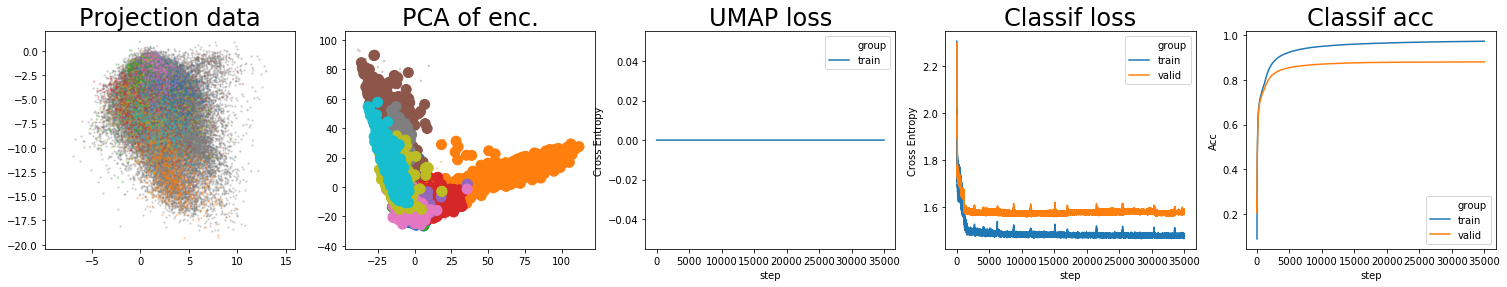

batch: 35000 | train acc: 0.9727 | val acc: 0.8804
tf.Tensor(0.8804459, shape=(), dtype=float32) 0.8701252841949463
saving weights


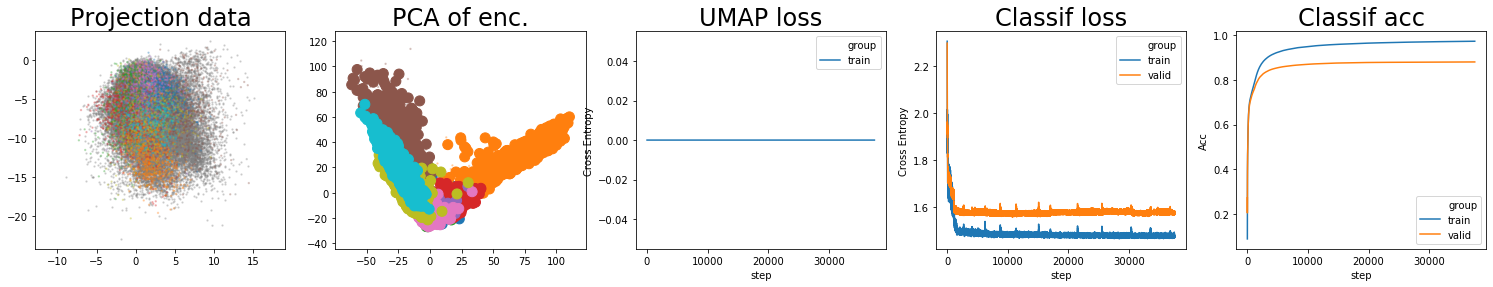

batch: 37500 | train acc: 0.9735 | val acc: 0.8807
tf.Tensor(0.8807267, shape=(), dtype=float32) 0.8704458975791931
saving weights


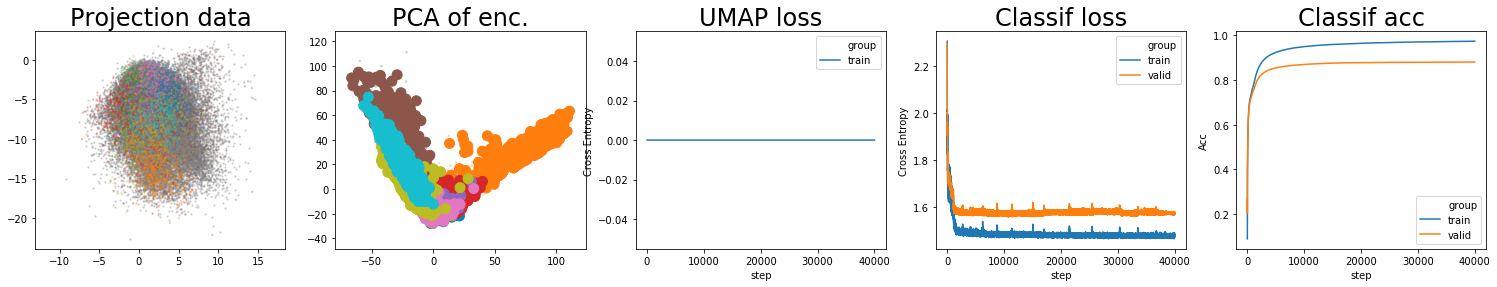

batch: 40000 | train acc: 0.9741 | val acc: 0.8811
tf.Tensor(0.88109636, shape=(), dtype=float32) 0.87072669506073
saving weights


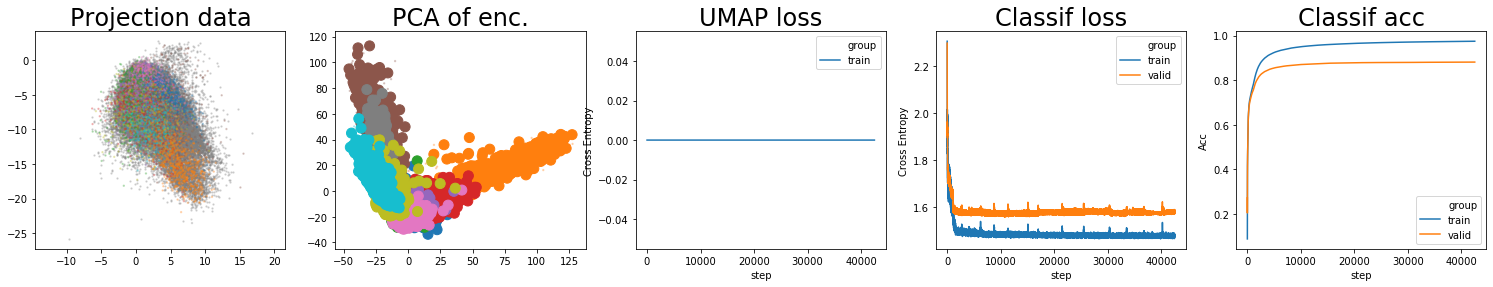

batch: 42500 | train acc: 0.9747 | val acc: 0.8812
tf.Tensor(0.88120526, shape=(), dtype=float32) 0.8710963630676269
saving weights


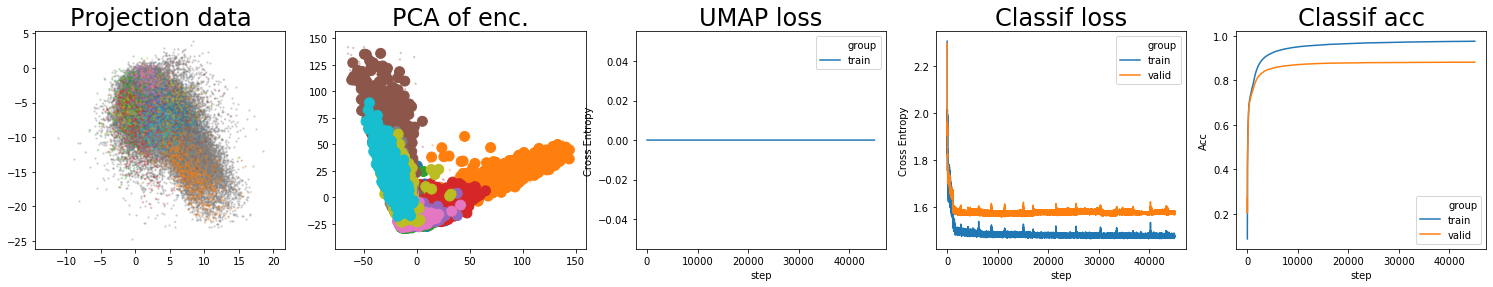

batch: 45000 | train acc: 0.9752 | val acc: 0.8813
tf.Tensor(0.88131315, shape=(), dtype=float32) 0.8712052607536316
saving weights


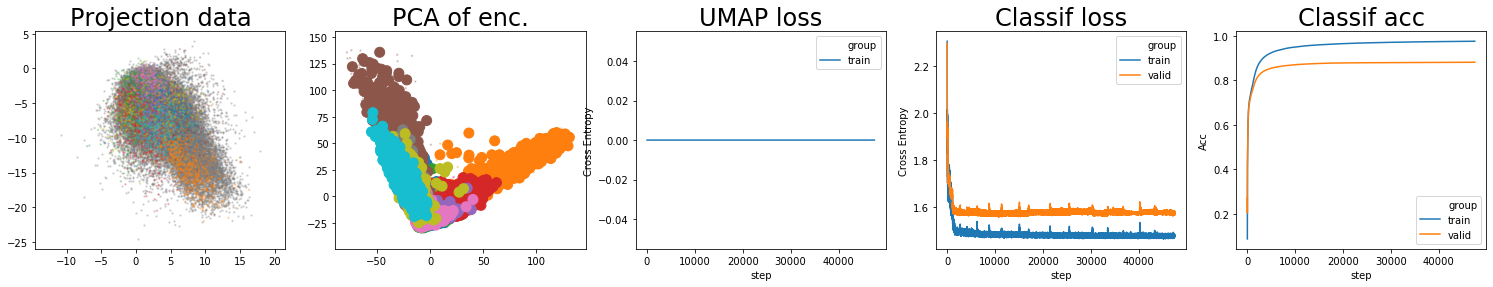

batch: 47500 | train acc: 0.9758 | val acc: 0.8815
tf.Tensor(0.8814629, shape=(), dtype=float32) 0.871313145160675
saving weights


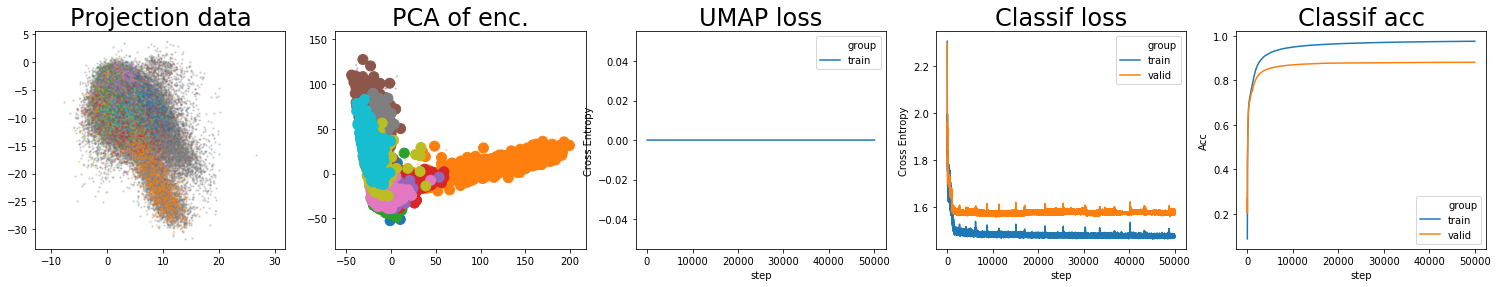

batch: 50000 | train acc: 0.9762 | val acc: 0.8816
tf.Tensor(0.8816145, shape=(), dtype=float32) 0.8714628720283508
saving weights


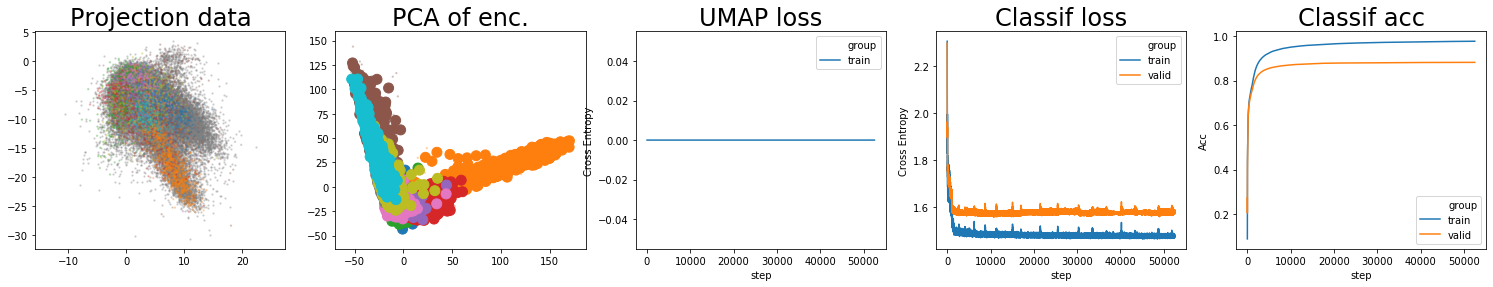

batch: 52500 | train acc: 0.9766 | val acc: 0.8817
tf.Tensor(0.88170046, shape=(), dtype=float32) 0.8716145062446594
saving weights


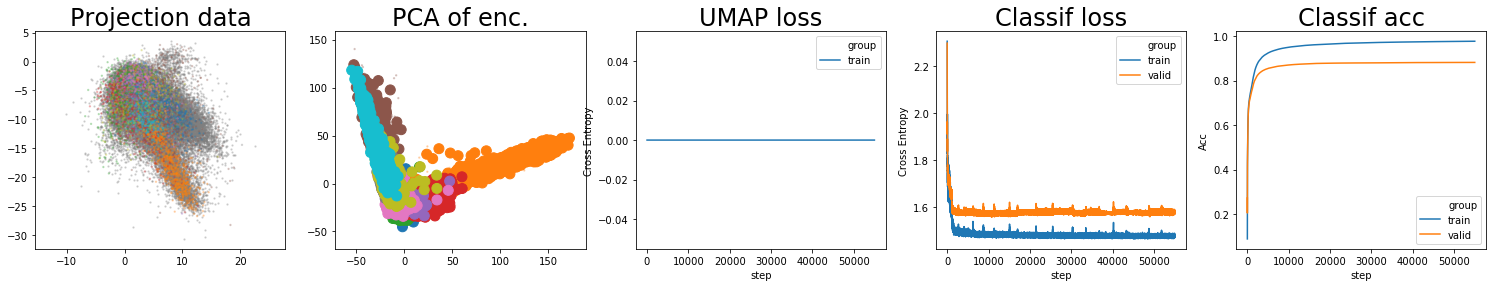

batch: 55000 | train acc: 0.977 | val acc: 0.8818
tf.Tensor(0.8818094, shape=(), dtype=float32) 0.8717004561424255
saving weights


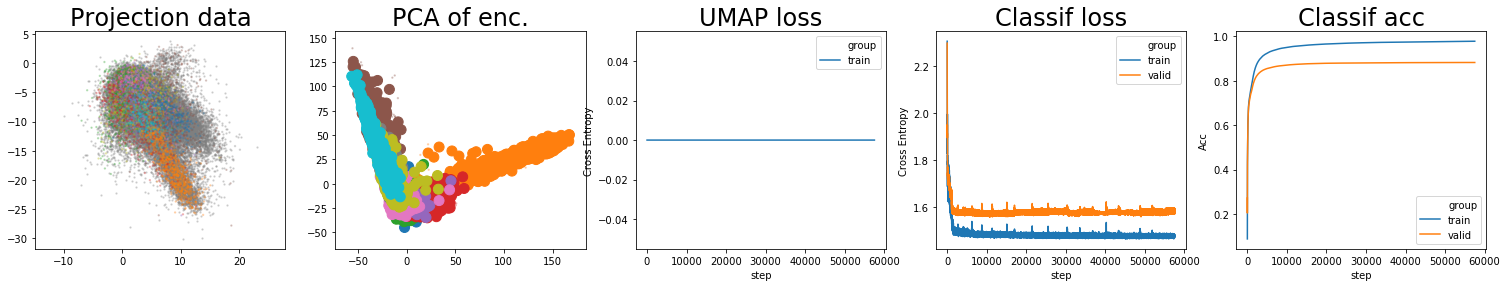

batch: 57500 | train acc: 0.9774 | val acc: 0.8818
tf.Tensor(0.8818182, shape=(), dtype=float32) 0.8718094134330749
saving weights


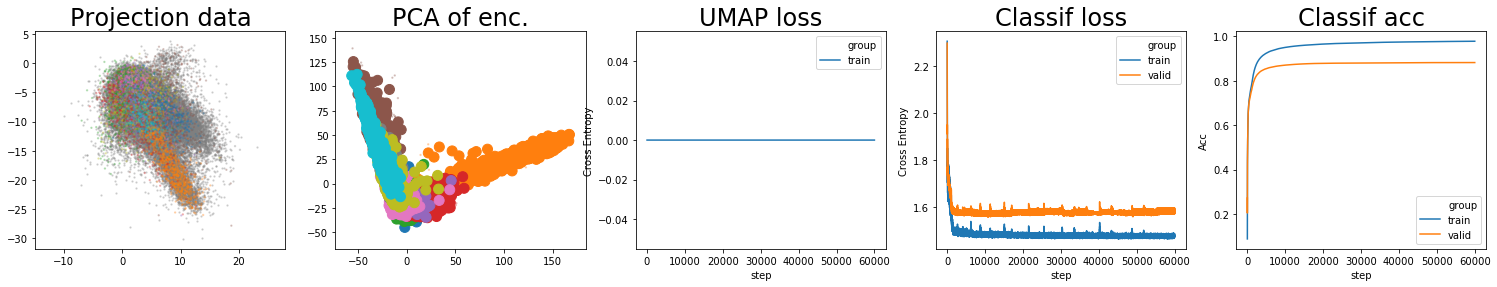

batch: 60000 | train acc: 0.9778 | val acc: 0.8818
tf.Tensor(0.88180923, shape=(), dtype=float32) 0.8718181753158569


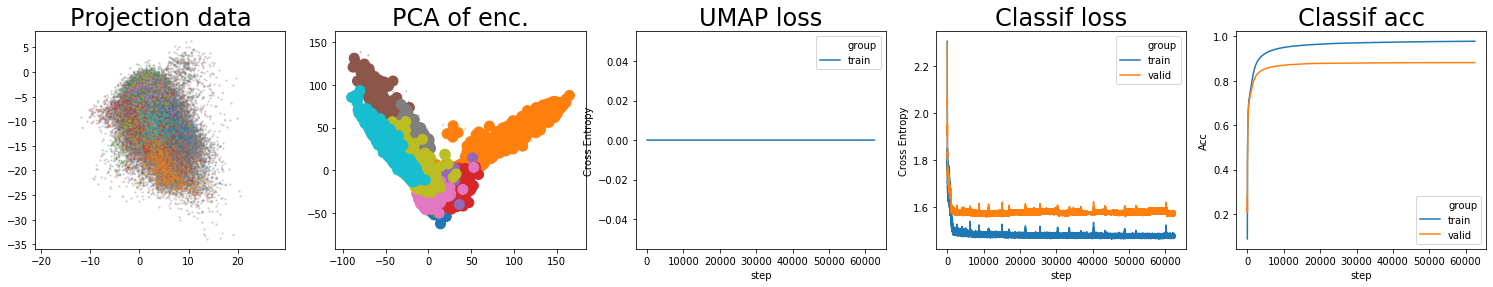

batch: 62500 | train acc: 0.978 | val acc: 0.8819
tf.Tensor(0.8819398, shape=(), dtype=float32) 0.8718181753158569
saving weights


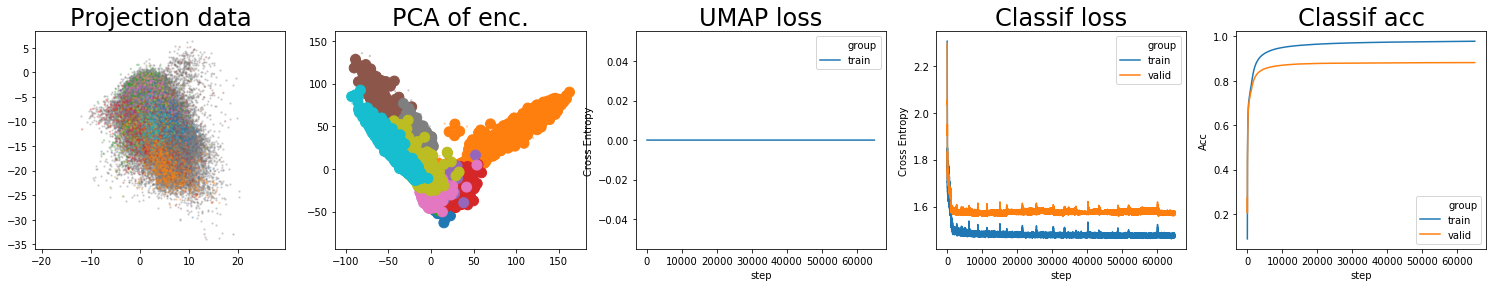

batch: 65000 | train acc: 0.9783 | val acc: 0.8821
tf.Tensor(0.8821473, shape=(), dtype=float32) 0.8719398283958435
saving weights


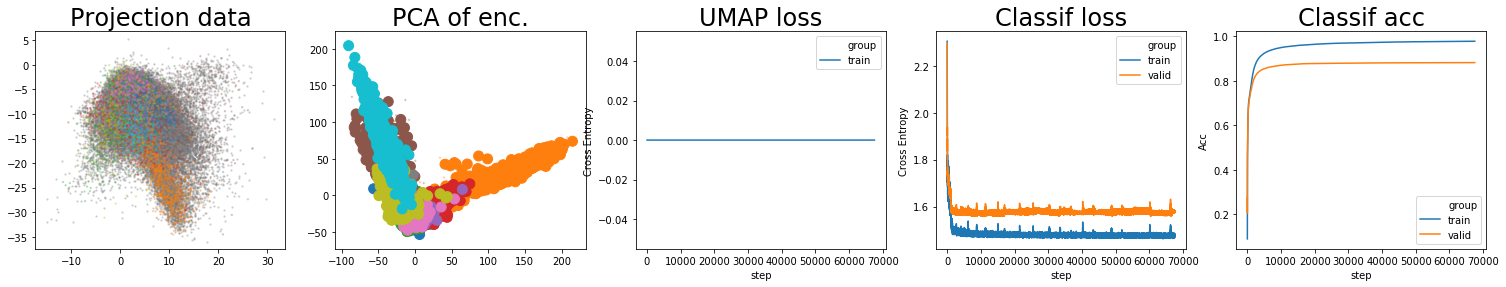

batch: 67500 | train acc: 0.9785 | val acc: 0.8823
tf.Tensor(0.88226545, shape=(), dtype=float32) 0.8721473121643066
saving weights


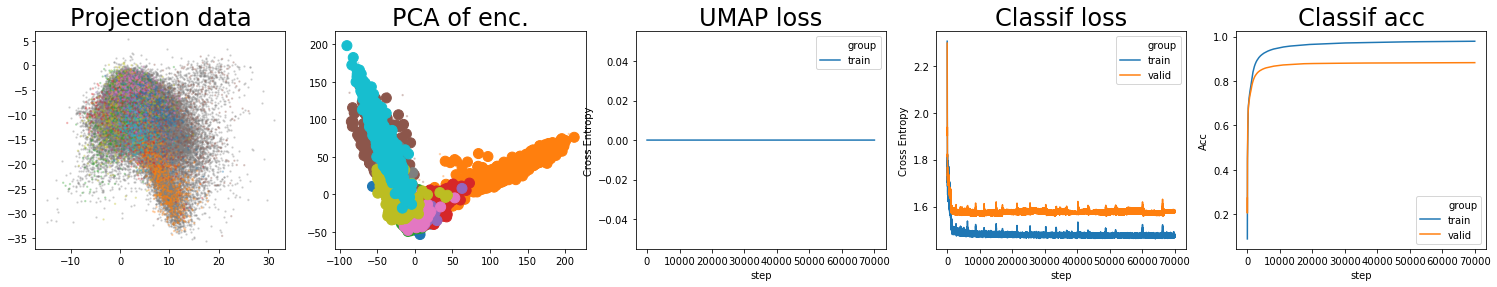

batch: 70000 | train acc: 0.9788 | val acc: 0.8823
tf.Tensor(0.8822989, shape=(), dtype=float32) 0.8722654485702515
saving weights


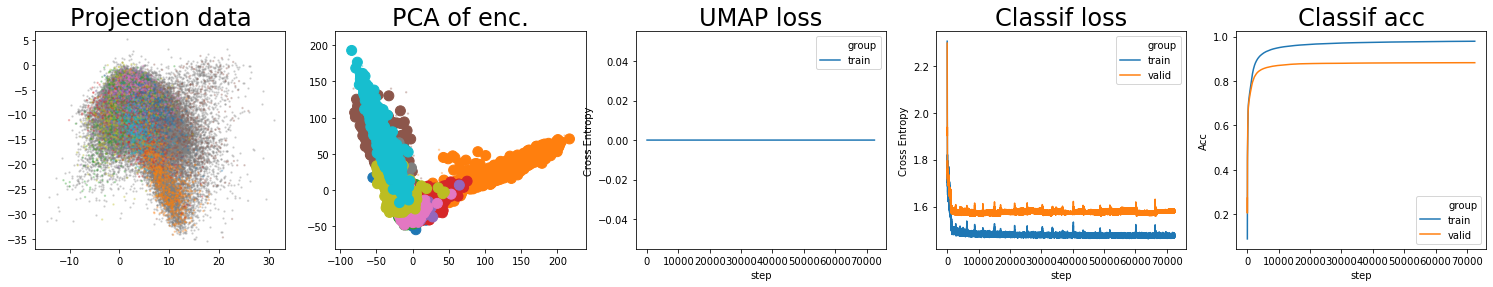

batch: 72500 | train acc: 0.979 | val acc: 0.8823
tf.Tensor(0.8823026, shape=(), dtype=float32) 0.8722988867759705
saving weights


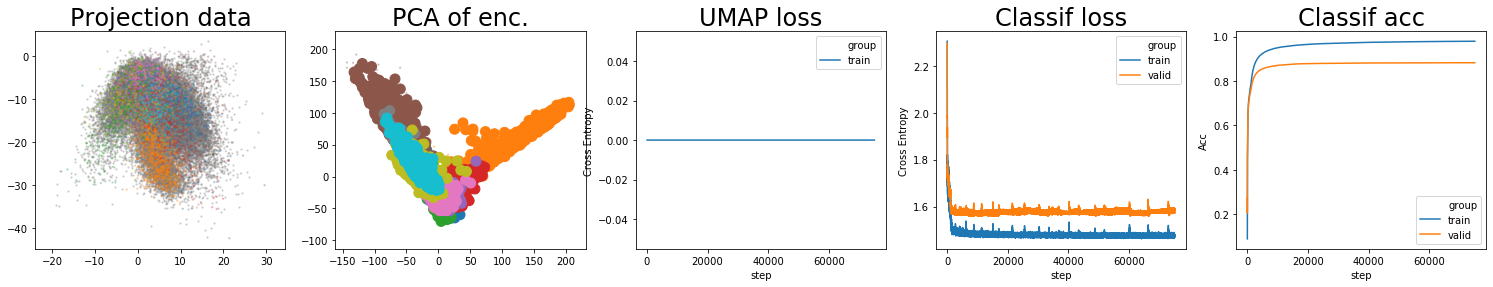

batch: 75000 | train acc: 0.9792 | val acc: 0.8823
tf.Tensor(0.88226014, shape=(), dtype=float32) 0.8723025822639465
Early stopping


In [29]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    for (batch_to, batch_from), (X, y), (X_val, y_val) in tqdm(
        zip(edge_epoch, labeled_iter, data_valid), total=BATCHES_PER_EPOCH, leave=False
    ):

        # train
        (
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
            classifier_acc,
        ) = model.train(
            batch_to=X_train[batch_to], batch_from=X_train[batch_from], X=X, y=y
        )

        # compute validation loss
        val_loss, val_acc = compute_classifier_loss(
            X_val,
            y_val,
            model.encoder,
            model.classifier,
            model.sparse_ce,
            model.class_acc_val,
        )

        # save losses
        model.write_losses(
            tf.convert_to_tensor(batch, dtype=tf.int64),
            classifier_acc,
            classifier_loss,
            umap_loss,
            val_loss,
            val_acc,
        )
        
        # plot results
        if batch % plot_frequency == 0:
            plot_umap_classif_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )
            print(
                "batch: {} | train acc: {} | val acc: {}".format(
                    str(batch),
                    str(round(classifier_acc.numpy(), 4)),
                    str(round(val_acc.numpy(), 4)),
                )
            )
        
        #### save network
        if batch % save_frequency == 0:
            print(val_acc , (best_saved_acc - max_reinitialize_delta))
            if val_acc > best_saved_acc:
                # save weights
                print('saving weights')
                model.encoder.save_weights((cpt_path / str(batch) / 'encoder').as_posix())
                model.embedder.save_weights((cpt_path / str(batch) / 'embedder').as_posix())
                model.classifier.save_weights((cpt_path / str(batch) / 'classifier').as_posix())
                best_saved_acc = val_acc.numpy()
                # save batch number
                best_saved_batch = copy.deepcopy(batch)
            
            elif val_acc < (best_saved_acc - max_reinitialize_delta):
                # reload weights
                print('reloading weights')
                model.encoder.load_weights((cpt_path / str(best_saved_batch) / 'encoder').as_posix())
                model.embedder.load_weights((cpt_path / str(best_saved_batch) / 'embedder').as_posix())
                model.classifier.load_weights((cpt_path / str(best_saved_batch) / 'classifier').as_posix())
                
                # reset batch
                batch = copy.deepcopy(best_saved_batch)
                # reset optimizer
                for var in model.optimizer.variables():
                    var.assign(tf.zeros_like(var))
                    
                # continue on with newly updated batch (past early stopping)
                continue
        
        #### early stopping
        # if there is an imporovement, set new best score
        if val_acc > best_acc + min_delta:
            last_improvement = 0
            best_acc = val_acc
        else:
            # if model has not improved and patience has been surpassed, quit
            if last_improvement>= patience:
                print('Early stopping')
                early_stopping = True
                break
            else:
                last_improvement+=1
            
        batch += 1
    if early_stopping:
        break

In [30]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

from tfumap.semisupervised_plotting import embed_data

loss_df = retrieve_tensors(model.tensorboard_logdir)
loss_df['step'] +=1
loss_df

wall_time   step       val  group      variable
0      1.595997e+09      1  0.088000  train   classif_acc
1      1.595997e+09      2  0.219500  train   classif_acc
2      1.595997e+09      3  0.238333  train   classif_acc
3      1.595997e+09      4  0.245000  train   classif_acc
4      1.595997e+09      5  0.268800  train   classif_acc
...             ...    ...       ...    ...           ...
75882  1.595999e+09  75883  1.592593  valid  classif_loss
75883  1.595999e+09  75884  1.575094  valid  classif_loss
75884  1.595999e+09  75885  1.572015  valid  classif_loss
75885  1.595999e+09  75886  1.580433  valid  classif_loss
75886  1.595999e+09  75887  1.578558  valid  classif_loss

[379435 rows x 5 columns]

In [31]:
loss_df.to_pickle(cpt_path/'loss_df')

In [32]:
valid_acc = loss_df[
    (loss_df.group.values == "valid") & (loss_df.variable.values == "classif_acc")
].val.values

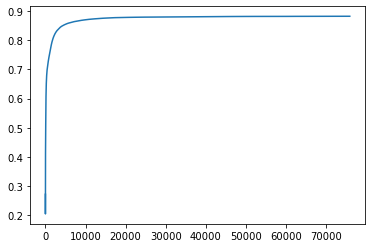

In [33]:
plt.plot(valid_acc)